In [ ]:
import os
import pandas as pd

# -------------------------------
# Paths - update these if needed
# -------------------------------
chest_xray_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray"
covid19_dir = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset"
covid_qu_ex_dir = "/kaggle/input/covid-qu-ex/COVID-QU-Ex"
pneumonia_way_dir = "/kaggle/input/pneumonia-xray-images"  # New dataset
s
data = []

# -------------------------------
# 1. Chest X-ray Pneumonia Dataset
# -------------------------------
for split in ["train", "val", "test"]:
    for label in ["PNEUMONIA", "NORMAL"]:
        folder = os.path.join(chest_xray_dir, split, label)
        if not os.path.exists(folder):
            continue
        for img in os.listdir(folder):
            data.append([os.path.join(folder, img), label.lower(), "chest_xray"])

# -------------------------------
# 2. COVID-19 Radiography Database
# -------------------------------
covid_mapping = {
    "COVID": "covid",
    "Viral Pneumonia": "pneumonia",   # merge viral pneumonia into pneumonia
    "Lung_Opacity": "pneumonia",     # can treat as pneumonia
    "Normal": "normal"
}

for folder in os.listdir(covid19_dir):
    if folder not in covid_mapping:
        continue
    label = covid_mapping[folder]
    folder_path = os.path.join(covid19_dir, folder, "images")
    if not os.path.exists(folder_path):  # some versions store images directly
        folder_path = os.path.join(covid19_dir, folder)
    for img in os.listdir(folder_path):
        data.append([os.path.join(folder_path, img), label, "covid19_radiography"])

# -------------------------------
# 3. COVID-QU-Ex Dataset (only COVID-19 extracted)
# -------------------------------
for split in ["train", "val", "test"]:
    covid19_folder = os.path.join(covid_qu_ex_dir, split, "COVID-19")
    if not os.path.exists(covid19_folder):
        continue

    images_path = os.path.join(covid19_folder, "images")
    if os.path.exists(images_path):
        for img in os.listdir(images_path):
            data.append([os.path.join(images_path, img), "covid", "covid_qu_ex"])

# -------------------------------
# 4. Pneumonia Way Images Dataset
# -------------------------------
if os.path.exists(pneumonia_way_dir):
    for split in os.listdir(pneumonia_way_dir):  # dynamically read splits
        split_path = os.path.join(pneumonia_way_dir, split)
        if not os.path.isdir(split_path):
            continue

        for label in os.listdir(split_path):
            label_path = os.path.join(split_path, label)
            if not os.path.isdir(label_path):
                continue

            mapped_label = "pneumonia" if label.lower() == "opacity" else label.lower()

            for img in os.listdir(label_path):
                if img.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif')):
                    data.append([os.path.join(label_path, img), mapped_label, "pneumonia_way"])


# -------------------------------
# Save Combined Dataset to CSV
# -------------------------------
df = pd.DataFrame(data, columns=["filepath", "label", "source"])
df.to_csv("/kaggle/working/combined_dataset.csv", index=False)

print("✅ combined_dataset.csv created with shape:", df.shape)
print("\nLabel distribution:")
print(df['label'].value_counts())
print("\nSource distribution:")
print(df['source'].value_counts())

✅ combined_dataset.csv created with shape: (44826, 3)

Label distribution:
label
pneumonia    15903
covid        15565
normal       13358
Name: count, dtype: int64

Source distribution:
source
covid19_radiography    21165
covid_qu_ex            11949
chest_xray              5856
pneumonia_way           5856
Name: count, dtype: int64


In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# --------------------
# 1. Load combined dataset
# --------------------
df = pd.read_csv("/kaggle/working/combined_dataset.csv")
df = df.rename(columns={"filepath": "file_path"})


# Split train, val, test
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, stratify=train_df['label'], random_state=42)

print("Train size:", len(train_df))
print("Val size:", len(val_df))
print("Test size:", len(test_df))

# --------------------
# 2. Image generators (with basic augmentation)
# --------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='file_path', y_col='label',
    target_size=(224,224), class_mode='categorical',
    batch_size=32, shuffle=True
)

val_gen = val_test_datagen.flow_from_dataframe(
    val_df, x_col='file_path', y_col='label',
    target_size=(224,224), class_mode='categorical',
    batch_size=32, shuffle=False
)

test_gen = val_test_datagen.flow_from_dataframe(
    test_df, x_col='file_path', y_col='label',
    target_size=(224,224), class_mode='categorical',
    batch_size=32, shuffle=False
)

2025-09-04 06:50:27.526840: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756968627.705075      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756968627.760285      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Train size: 32274
Val size: 3586
Test size: 8966
Found 32274 validated image filenames belonging to 3 classes.
Found 3586 validated image filenames belonging to 3 classes.
Found 8966 validated image filenames belonging to 3 classes.


In [7]:
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPU Devices:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
Num GPUs Available: 1
GPU Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization


# --------------------
# 3. Build DenseNet121 model
# --------------------
base_model = DenseNet121(
    weights='/kaggle/input/densenet/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5',  # must be a direct .h5 weight file
    include_top=False,
    input_shape=(224, 224, 3)
)

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)  # Add batch normalization
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)  # Increased neurons
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output = Dense(3, activation='softmax', kernel_regularizer=l2(0.001))(x)

model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False  # Freeze base DenseNet121 first

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

I0000 00:00:1756968786.804072      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [9]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(train_df['label'])
weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_df['label'])
class_weights = dict(zip(range(len(classes)), weights))

print("Class weights:", class_weights)

Class weights: {0: 0.9599357544391898, 1: 1.11864406779661, 2: 0.9395633187772926}


In [10]:
# --------------------
# Phase 1: Train only top layers
# --------------------
print("Phase 1: Training top layers only...")
EPOCHS_PHASE1 = 15
BATCH_SIZE = 16  # Reduced batch size for better gradients

# Enhanced callbacks
callbacks_phase1 = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4, min_lr=1e-7, verbose=1)
]

history_phase1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_PHASE1,
    batch_size=BATCH_SIZE,
    class_weight=class_weights,
    callbacks=callbacks_phase1,
    verbose=1
)


Phase 1: Training top layers only...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1756968814.839203      94 service.cc:148] XLA service 0x481ebc90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756968814.840176      94 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1756968817.761727      94 cuda_dnn.cc:529] Loaded cuDNN version 90300


   2/1009 ━━━━━━━━━━━━━━━━━━━━ 54s 54ms/step - accuracy: 0.3281 - loss: 2.2953 - precision: 0.3467 - recall: 0.2812    

I0000 00:00:1756968829.917350      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 787s 744ms/step - accuracy: 0.5878 - loss: 1.5649 - precision: 0.6069 - recall: 0.5505 - val_accuracy: 0.8215 - val_loss: 0.9155 - val_precision: 0.8402 - val_recall: 0.7978 - learning_rate: 1.0000e-04
Epoch 2/15
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 469s 464ms/step - accuracy: 0.7349 - loss: 1.0991 - precision: 0.7551 - recall: 0.7117 - val_accuracy: 0.8344 - val_loss: 0.8375 - val_precision: 0.8543 - val_recall: 0.8162 - learning_rate: 1.0000e-04
Epoch 3/15
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 467s 463ms/step - accuracy: 0.7714 - loss: 0.9843 - precision: 0.7900 - recall: 0.7510 - val_accuracy: 0.8461 - val_loss: 0.7890 - val_precision: 0.8600 - val_recall: 0.8271 - learning_rate: 1.0000e-04
Epoch 4/15
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 482s 478ms/step - accuracy: 0.7839 - loss: 0.9281 - precision: 0.8022 - recall: 0.7604 - val_accuracy: 0.8503 - val_loss: 0.7517 - val_precision: 0.8635 - val_recall: 0.8291 - learning_rate: 1.0000e-04
Epoch 5/15
1009/1009 ━━━━━━━━━━━━━━

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
# --------------------
# Phase 2: Fine-tune entire model
# --------------------
print("Phase 2: Fine-tuning entire model...")

# Unfreeze all layers
for layer in base_model.layers:
    layer.trainable = True

# Use much lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Much lower LR
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

EPOCHS_PHASE2 = 20

# Custom learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

callbacks_phase2 = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-8, verbose=1),
    LearningRateScheduler(scheduler, verbose=1)
]

history_phase2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_PHASE2,
    batch_size=BATCH_SIZE,
    class_weight=class_weights,
    callbacks=callbacks_phase2,
    verbose=1
)

Phase 2: Fine-tuning entire model...

Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 1/20
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 768s 588ms/step - accuracy: 0.7877 - loss: 0.7216 - precision: 0.8068 - recall: 0.7640 - val_accuracy: 0.9030 - val_loss: 0.4331 - val_precision: 0.9089 - val_recall: 0.8954 - learning_rate: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 2/20
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 493s 489ms/step - accuracy: 0.8886 - loss: 0.4819 - precision: 0.8983 - recall: 0.8766 - val_accuracy: 0.9225 - val_loss: 0.3857 - val_precision: 0.9257 - val_recall: 0.9172 - learning_rate: 1.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 3/20
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 493s 488ms/step - accuracy: 0.9143 - loss: 0.4143 - precision: 0.9215 - recall: 0.9064 - val_accuracy: 0.9102 - val_loss: 0.4114 - val_precision: 0.9151 - val_recall: 0.9074 - learning_rate: 1.

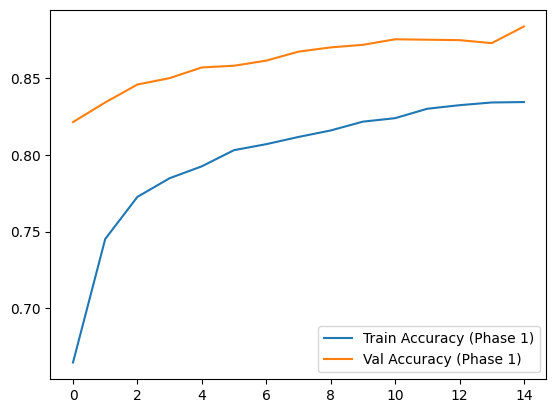

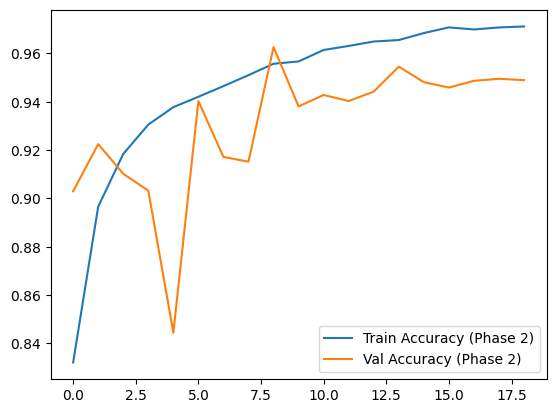

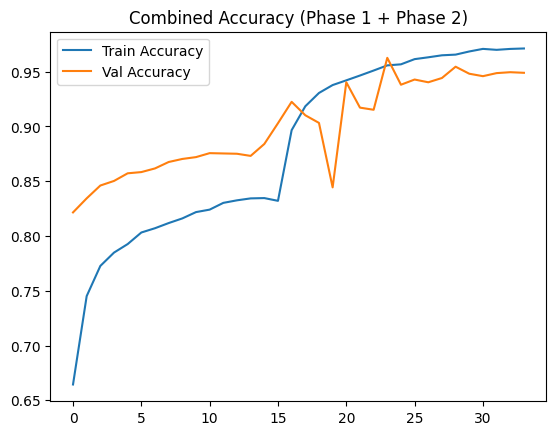

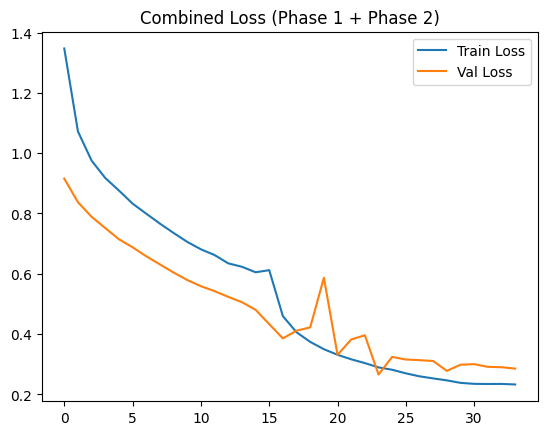

In [12]:
import matplotlib.pyplot as plt

# Phase 1 plots
plt.plot(history_phase1.history['accuracy'], label='Train Accuracy (Phase 1)')
plt.plot(history_phase1.history['val_accuracy'], label='Val Accuracy (Phase 1)')
plt.legend()
plt.show()

# Phase 2 plots
plt.plot(history_phase2.history['accuracy'], label='Train Accuracy (Phase 2)')
plt.plot(history_phase2.history['val_accuracy'], label='Val Accuracy (Phase 2)')
plt.legend()
plt.show()

acc = history_phase1.history['accuracy'] + history_phase2.history['accuracy']
val_acc = history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy']
loss = history_phase1.history['loss'] + history_phase2.history['loss']
val_loss = history_phase1.history['val_loss'] + history_phase2.history['val_loss']

plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.title("Combined Accuracy (Phase 1 + Phase 2)")
plt.legend()
plt.show()

plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title("Combined Loss (Phase 1 + Phase 2)")
plt.legend()
plt.show()


In [13]:
# --------------------
# 5. Evaluate model
# --------------------

loss, acc, precision, recall = model.evaluate(test_gen)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")

# Get true labels
y_true = test_df['label'].values

# Predict and map to label strings
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

# Map numeric predictions to string labels
index_to_label = {v: k for k, v in test_gen.class_indices.items()}
y_pred_labels = [index_to_label[i] for i in y_pred_classes]

# Class names
target_names = list(test_gen.class_indices.keys())

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_labels, target_names=target_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_labels, labels=target_names)
print("\nConfusion Matrix:")
print(cm)


281/281 ━━━━━━━━━━━━━━━━━━━━ 113s 403ms/step - accuracy: 0.9650 - loss: 0.2575 - precision: 0.9659 - recall: 0.9638
Test Loss: 0.2572
Test Accuracy: 0.9644
Test Precision: 0.9654
Test Recall: 0.9635
281/281 ━━━━━━━━━━━━━━━━━━━━ 67s 200ms/step

Classification Report:
              precision    recall  f1-score   support

       covid       1.00      0.97      0.98      3113
      normal       0.93      0.98      0.95      2672
   pneumonia       0.97      0.95      0.96      3181

    accuracy                           0.96      8966
   macro avg       0.96      0.97      0.96      8966
weighted avg       0.97      0.96      0.96      8966


Confusion Matrix:
[[3021   52   40]
 [   4 2609   59]
 [   7  157 3017]]


In [14]:
model.save("modelAddedDataset.h5")

# **Grad-Cam Visualization**

In [5]:
from tensorflow.keras.models import load_model
model = load_model("/kaggle/input/modeladdeddataset/modelAddedDataset.h5")

Using layers: ['conv5_block16_1_conv', 'conv5_block16_1_relu', 'conv5_block16_2_conv', 'conv5_block16_concat', 'relu']

Analyzing COVID-19...
True Label: COVID-19
Prediction: COVID-19 (confidence: 0.990)
Correct: ✓
✓ Successfully processed layer: conv5_block16_1_conv
✓ Successfully processed layer: conv5_block16_1_relu
✓ Successfully processed layer: conv5_block16_2_conv
✓ Successfully processed layer: conv5_block16_concat
✓ Successfully processed layer: relu
Computing Integrated Gradients...
✓ Integrated Gradients computed successfully

Localization Metrics:
----------------------------------------
conv5_block16_1_conv: Focus=0.024, Concentration=1.000, Coverage=0.020, Precision=0.017
conv5_block16_1_relu: Focus=0.179, Concentration=0.494, Coverage=0.565, Precision=0.243
conv5_block16_2_conv: Focus=0.285, Concentration=0.411, Coverage=0.774, Precision=0.258
conv5_block16_concat: Focus=0.263, Concentration=0.438, Coverage=0.715, Precision=0.236
relu                : Focus=0.255, Concen

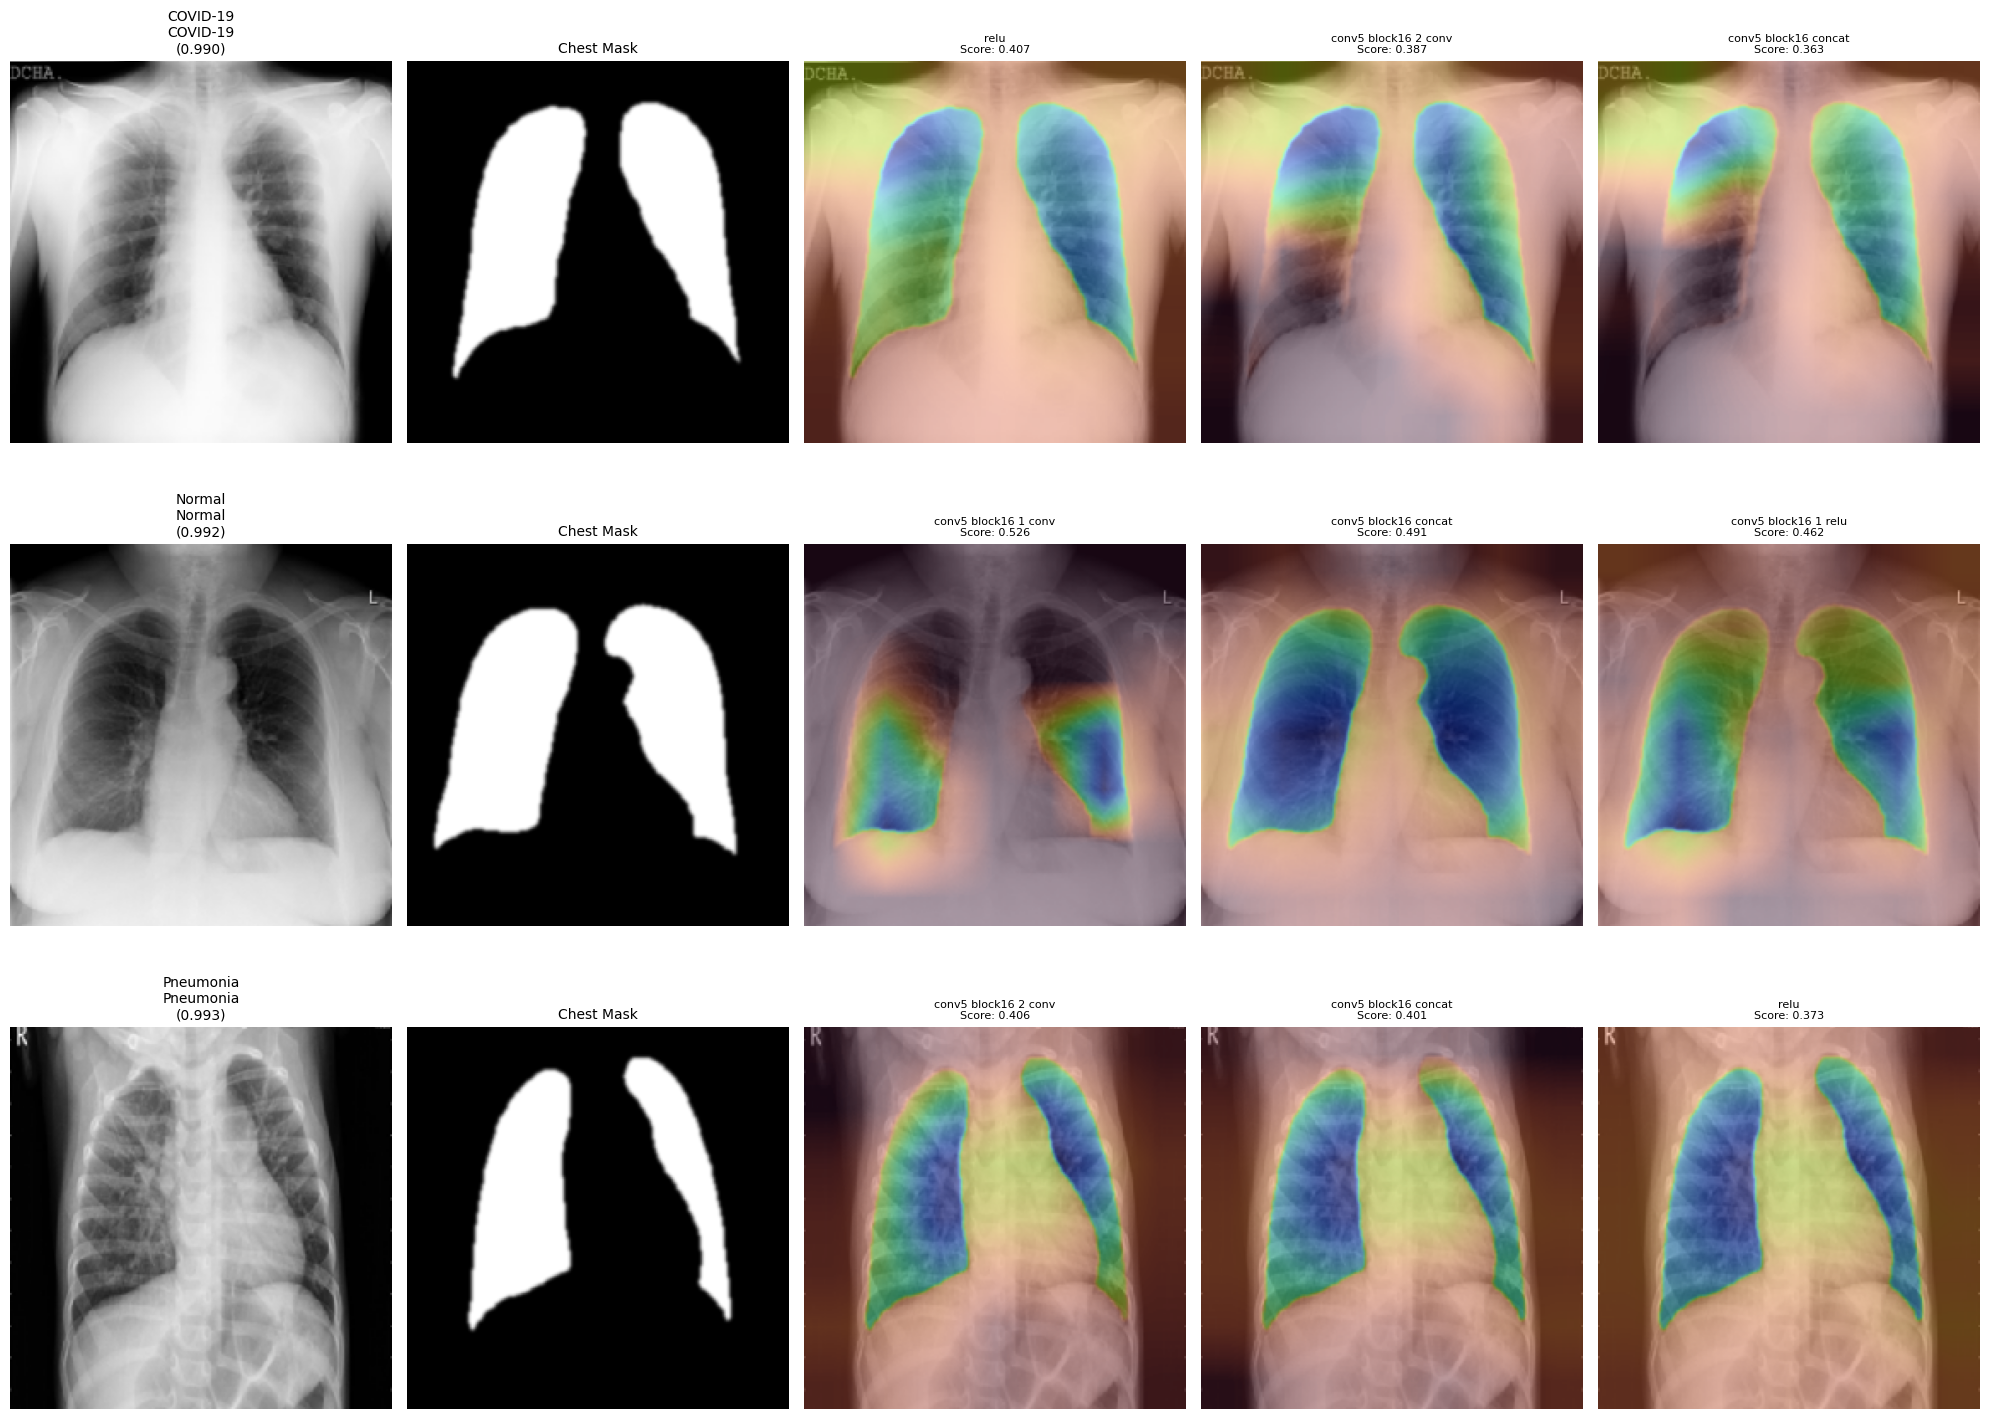


ANALYSIS SUMMARY
Successfully analyzed: 3/3 images

Best performing methods:
  relu: 1 times
  conv5_block16_1_conv: 1 times
  conv5_block16_2_conv: 1 times


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from sklearn.metrics import jaccard_score

# =============================
# 1. Enhanced chest region detection with error handling
# =============================
def load_chest_mask(mask_path, img_size=(224, 224)):
    """
    Load provided lung/chest mask from dataset and preprocess
    Enhanced with better error handling and validation
    """
    try:
        # Load mask with proper error handling
        mask = tf.keras.preprocessing.image.load_img(
            mask_path, target_size=img_size, color_mode="grayscale"
        )
        mask_array = tf.keras.preprocessing.image.img_to_array(mask)
        mask_array = mask_array.squeeze() / 255.0  # normalize to [0,1]
        
        # Validate mask
        if mask_array.shape != img_size:
            mask_array = cv2.resize(mask_array, img_size)
        
        # Enhanced preprocessing
        # Apply morphological operations to clean up the mask
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        mask_array = cv2.morphologyEx(mask_array, cv2.MORPH_CLOSE, kernel)
        
        # Optional smoothing with better parameters
        mask_array = cv2.GaussianBlur(mask_array, (5, 5), 1.0)
        
        # Ensure binary nature while keeping smooth edges
        mask_array = np.clip(mask_array, 0, 1)
        
        return mask_array
    
    except Exception as e:
        print(f"Error loading mask from {mask_path}: {e}")
        # Return default mask (center region)
        mask_array = np.zeros(img_size)
        center_x, center_y = img_size[0] // 2, img_size[1] // 2
        mask_array[center_y-80:center_y+80, center_x-60:center_x+60] = 1.0
        return mask_array

# =============================
# 2. Improved Multi-layer Grad-CAM with better layer selection
# =============================
def get_optimal_layers(model):
    """
    Automatically find the best convolutional layers for Grad-CAM
    """
    conv_layers = []
    for layer in model.layers:
        if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.DepthwiseConv2D)):
            conv_layers.append(layer.name)
        # For concatenation layers (like DenseNet)
        elif 'concat' in layer.name.lower():
            conv_layers.append(layer.name)
        # For activation layers after conv
        elif any(name in layer.name.lower() for name in ['relu', 'activation']):
            if len(conv_layers) > 0:  # Only if we have conv layers before
                conv_layers.append(layer.name)
    
    # Return last few layers
    return conv_layers[-5:] if len(conv_layers) >= 5 else conv_layers

def compare_gradcam_layers(img_array, model, layer_names=None, pred_index=None):
    """
    Compare Grad-CAM results across different layers with auto-detection
    """
    if layer_names is None:
        layer_names = get_optimal_layers(model)
        print(f"Auto-detected layers: {layer_names}")
    
    results = {}
    
    for layer_name in layer_names:
        try:
            heatmap = make_gradcam_heatmap(img_array, model, layer_name, pred_index)
            if heatmap is not None:
                results[layer_name] = heatmap
                print(f"✓ Successfully processed layer: {layer_name}")
        except Exception as e:
            print(f"✗ Failed to process layer {layer_name}: {e}")
            
    return results

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Enhanced Grad-CAM with better gradient handling and normalization
    """
    try:
        # Validate layer exists
        try:
            target_layer = model.get_layer(last_conv_layer_name)
        except ValueError:
            print(f"Layer '{last_conv_layer_name}' not found in model")
            return None
        
        grad_model = tf.keras.models.Model(
            inputs=model.inputs,
            outputs=[target_layer.output, model.output]
        )
        
        with tf.GradientTape() as tape:
            conv_outputs, predictions = grad_model(img_array)
            if pred_index is None:
                pred_index = tf.argmax(predictions[0])
            class_channel = predictions[:, pred_index]
        
        grads = tape.gradient(class_channel, conv_outputs)
        
        # Handle None gradients
        if grads is None:
            print(f"No gradients computed for layer {last_conv_layer_name}")
            return None
        
        # Improved gradient processing
        # Use ReLU on gradients (standard Grad-CAM)
        grads = tf.maximum(grads, 0)
        
        # Global Average Pooling of gradients
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        
        # Weight the feature maps
        conv_outputs = conv_outputs[0]
        heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)
        
        # Apply ReLU to heatmap
        heatmap = tf.maximum(heatmap, 0)
        
        # Enhanced normalization with stability
        heatmap_max = tf.math.reduce_max(heatmap)
        if heatmap_max > 1e-8:  # Avoid division by very small numbers
            heatmap = heatmap / heatmap_max
        else:
            print(f"Warning: Very small or zero heatmap values for {last_conv_layer_name}")
            return None
        
        return heatmap.numpy()
    
    except Exception as e:
        print(f"Error in Grad-CAM for layer {last_conv_layer_name}: {e}")
        return None

# =============================
# 3. Improved Integrated Gradients with better baseline
# =============================
def integrated_gradients(model, img_array, target_class, baseline=None, steps=50):
    """
    Integrated Gradients with improved baseline selection and error handling
    """
    try:
        if baseline is None:
            # Better baseline: use blurred image instead of zeros
            baseline = tf.image.resize(img_array, (32, 32))
            baseline = tf.image.resize(baseline, img_array.shape[1:3])
            # Add some gaussian noise
            baseline = baseline + tf.random.normal(baseline.shape, stddev=0.02)
            baseline = tf.clip_by_value(baseline, 0, 1)
        
        # Generate interpolated inputs
        alphas = tf.linspace(0.0, 1.0, steps + 1)
        gradient_batches = []
        
        for alpha in alphas:
            interpolated = baseline + alpha * (img_array - baseline)
            
            with tf.GradientTape() as tape:
                tape.watch(interpolated)
                predictions = model(interpolated)
                target_score = predictions[:, target_class]
            
            gradients = tape.gradient(target_score, interpolated)
            if gradients is not None:
                gradient_batches.append(gradients)
        
        if not gradient_batches:
            print("No valid gradients computed for Integrated Gradients")
            return None
        
        # Average gradients and multiply by input difference
        integrated_grads = tf.reduce_mean(gradient_batches, axis=0)
        integrated_grads = integrated_grads * (img_array - baseline)
        
        # Convert to heatmap - use L2 norm across channels
        attribution = tf.norm(integrated_grads, axis=-1)
        attribution = tf.squeeze(attribution)
        
        # Normalize
        attr_max = tf.reduce_max(attribution)
        if attr_max > 1e-8:
            attribution = attribution / attr_max
        
        return attribution.numpy()
    
    except Exception as e:
        print(f"Error in Integrated Gradients: {e}")
        return None

# =============================
# 4. Enhanced quality metrics with additional measures
# =============================
def calculate_localization_metrics(heatmap, chest_mask):
    """
    Calculate comprehensive metrics for localization quality
    """
    metrics = {}
    
    if chest_mask is None or heatmap is None:
        return metrics
    
    try:
        # Resize heatmap to match mask
        if heatmap.shape != chest_mask.shape:
            heatmap_resized = cv2.resize(heatmap, (chest_mask.shape[1], chest_mask.shape[0]))
        else:
            heatmap_resized = heatmap.copy()
        
        # Ensure non-negative values
        heatmap_resized = np.maximum(heatmap_resized, 0)
        chest_mask = np.maximum(chest_mask, 0)
        
        total_attention = np.sum(heatmap_resized)
        
        if total_attention < 1e-8:
            return {'focus_score': 0, 'concentration': 0, 'coverage': 0, 'precision': 0}
        
        # 1. Focus score (percentage of attention in chest region)
        chest_attention = np.sum(heatmap_resized * chest_mask)
        metrics['focus_score'] = chest_attention / total_attention
        
        # 2. Concentration score (how concentrated the attention is)
        top_20_percent = np.percentile(heatmap_resized, 80)
        concentrated_attention = np.sum(heatmap_resized[heatmap_resized > top_20_percent])
        metrics['concentration'] = concentrated_attention / total_attention
        
        # 3. Coverage score (how much of chest area is covered)
        threshold = 0.1 * np.max(heatmap_resized)
        active_chest = (heatmap_resized * chest_mask > threshold).astype(float)
        total_chest = np.sum(chest_mask > 0.1)
        metrics['coverage'] = np.sum(active_chest) / total_chest if total_chest > 0 else 0
        
        # 4. Precision score (IoU-like metric)
        heatmap_binary = (heatmap_resized > threshold).astype(float)
        chest_binary = (chest_mask > 0.1).astype(float)
        
        intersection = np.sum(heatmap_binary * chest_binary)
        union = np.sum(np.maximum(heatmap_binary, chest_binary))
        metrics['precision'] = intersection / union if union > 0 else 0
        
        return metrics
    
    except Exception as e:
        print(f"Error calculating metrics: {e}")
        return {}

# =============================
# 5. Enhanced visualization with better color schemes
# =============================
def create_comparison_visualization(img_pil, heatmaps_dict, chest_mask, alpha=0.4):
    """
    Create enhanced visualizations with better color schemes and overlays
    """
    img_array = np.array(img_pil)
    if len(img_array.shape) == 2:
        img_array = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)
    
    results = {}
    
    for method_name, heatmap in heatmaps_dict.items():
        if heatmap is not None:
            try:
                # Resize heatmap
                heatmap_resized = cv2.resize(heatmap, (img_array.shape[1], img_array.shape[0]))
                
                # Apply chest mask if available
                if chest_mask is not None:
                    chest_mask_resized = cv2.resize(chest_mask, (img_array.shape[1], img_array.shape[0]))
                    # Soft masking instead of hard masking
                    masked_heatmap = heatmap_resized * (0.3 + 0.7 * chest_mask_resized)
                else:
                    masked_heatmap = heatmap_resized
                
                # Normalize
                if np.max(masked_heatmap) > 0:
                    masked_heatmap = masked_heatmap / np.max(masked_heatmap)
                
                # Create colored overlay with better colormap
                heatmap_colored = np.uint8(255 * masked_heatmap)
                heatmap_colored = cv2.applyColorMap(heatmap_colored, cv2.COLORMAP_TURBO)
                
                # Enhanced blending
                overlay = cv2.addWeighted(img_array, 1-alpha, heatmap_colored, alpha, 0)
                results[method_name] = overlay
                
            except Exception as e:
                print(f"Error creating visualization for {method_name}: {e}")
                
    return results

# =============================
# 6. Main analysis function with better error handling
# =============================
def preprocess_image(img_path, img_size=(224, 224)):
    """
    Preprocess image with enhanced error handling
    """
    try:
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0
        return img, img_array
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
        return None, None

def comprehensive_gradcam_analysis(model, test_images, mask_paths, class_names):
    """
    Comprehensive analysis with enhanced error handling and reporting
    """
    # Auto-detect layers if not specified
    test_layers = get_optimal_layers(model)
    print(f"Using layers: {test_layers}")
    
    all_results = []
    fig_height = max(15, len(test_images) * 4)
    plt.figure(figsize=(20, fig_height))
    
    successful_analyses = 0
    
    for img_idx, (true_label, img_path) in enumerate(test_images.items()):
        print(f"\n{'='*50}")
        print(f"Analyzing {true_label}...")
        print(f"{'='*50}")
        
        # Preprocess image
        original_img, preprocessed_img = preprocess_image(img_path)
        if preprocessed_img is None:
            continue
        
        # Load dataset mask
        chest_mask = None
        if true_label in mask_paths:
            chest_mask = load_chest_mask(mask_paths[true_label], img_size=(224, 224))
        
        # Prediction
        try:
            preds = model.predict(preprocessed_img, verbose=0)
            pred_class = np.argmax(preds[0])
            pred_conf = np.max(preds[0])
            
            print(f"True Label: {true_label}")
            print(f"Prediction: {class_names[pred_class]} (confidence: {pred_conf:.3f})")
            print(f"Correct: {'✓' if class_names[pred_class] == true_label else '✗'}")
            
        except Exception as e:
            print(f"Error in prediction: {e}")
            continue
        
        # Grad-CAM across layers
        gradcam_results = compare_gradcam_layers(preprocessed_img, model, test_layers, pred_class)
        
        # Integrated Gradients
        try:
            print("Computing Integrated Gradients...")
            ig_result = integrated_gradients(model, preprocessed_img, pred_class, steps=30)
            if ig_result is not None:
                gradcam_results['Integrated_Gradients'] = ig_result
                print("✓ Integrated Gradients computed successfully")
        except Exception as e:
            print(f"✗ Integrated Gradients failed: {e}")
        
        # Calculate metrics
        method_metrics = {}
        print(f"\nLocalization Metrics:")
        print("-" * 40)
        
        for method_name, heatmap in gradcam_results.items():
            if heatmap is not None:
                metrics = calculate_localization_metrics(heatmap, chest_mask)
                method_metrics[method_name] = metrics
                print(f"{method_name:20s}: "
                      f"Focus={metrics.get('focus_score', 0):.3f}, "
                      f"Concentration={metrics.get('concentration', 0):.3f}, "
                      f"Coverage={metrics.get('coverage', 0):.3f}, "
                      f"Precision={metrics.get('precision', 0):.3f}")
        
        # Best method selection
        if method_metrics:
            # Weighted score combining multiple metrics
            for method_name in method_metrics:
                metrics = method_metrics[method_name]
                weighted_score = (
                    0.4 * metrics.get('focus_score', 0) +
                    0.3 * metrics.get('precision', 0) +
                    0.2 * metrics.get('coverage', 0) +
                    0.1 * metrics.get('concentration', 0)
                )
                method_metrics[method_name]['weighted_score'] = weighted_score
            
            best_method = max(method_metrics.keys(), 
                            key=lambda x: method_metrics[x]['weighted_score'])
            print(f"\nBest method for {true_label}: {best_method} "
                  f"(score: {method_metrics[best_method]['weighted_score']:.3f})")
        
        # Create visualizations
        visualizations = create_comparison_visualization(original_img, gradcam_results, chest_mask)
        
        # Plotting
        cols = 5  # original + mask + top 3 methods
        
        # Original image
        plt.subplot(len(test_images), cols, img_idx * cols + 1)
        plt.imshow(original_img)
        plt.title(f"{true_label}\n{class_names[pred_class]}\n({pred_conf:.3f})", fontsize=10)
        plt.axis('off')
        
        # Chest mask
        plt.subplot(len(test_images), cols, img_idx * cols + 2)
        if chest_mask is not None:
            plt.imshow(chest_mask, cmap='gray')
            plt.title("Chest Mask", fontsize=10)
        else:
            plt.text(0.5, 0.5, 'No Mask\nAvailable', ha='center', va='center', 
                    transform=plt.gca().transAxes)
            plt.title("Chest Mask", fontsize=10)
        plt.axis('off')
        
        # Top 3 methods
        if method_metrics:
            top_methods = sorted(method_metrics.keys(), 
                               key=lambda x: method_metrics[x]['weighted_score'], 
                               reverse=True)[:3]
        else:
            top_methods = list(visualizations.keys())[:3]
        
        for i, method in enumerate(top_methods):
            plt.subplot(len(test_images), cols, img_idx * cols + 3 + i)
            if method in visualizations:
                plt.imshow(visualizations[method])
                if method in method_metrics:
                    metrics = method_metrics[method]
                    plt.title(f"{method.replace('_', ' ')}\n"
                             f"Score: {metrics.get('weighted_score', 0):.3f}", 
                             fontsize=8)
                else:
                    plt.title(method.replace('_', ' '), fontsize=8)
            else:
                plt.text(0.5, 0.5, 'Not\nAvailable', ha='center', va='center', 
                        transform=plt.gca().transAxes)
                plt.title(method.replace('_', ' '), fontsize=8)
            plt.axis('off')
        
        all_results.append({
            'true_label': true_label,
            'prediction': class_names[pred_class],
            'confidence': pred_conf,
            'methods': method_metrics,
            'best_method': best_method if method_metrics else None
        })
        
        successful_analyses += 1
    
    plt.tight_layout()
    plt.savefig('gradcam_analysis_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Summary report
    print(f"\n{'='*60}")
    print("ANALYSIS SUMMARY")
    print(f"{'='*60}")
    print(f"Successfully analyzed: {successful_analyses}/{len(test_images)} images")
    
    if all_results:
        # Method performance summary
        method_counts = {}
        for result in all_results:
            if result['best_method']:
                method_counts[result['best_method']] = method_counts.get(result['best_method'], 0) + 1
        
        print(f"\nBest performing methods:")
        for method, count in sorted(method_counts.items(), key=lambda x: x[1], reverse=True):
            print(f"  {method}: {count} times")
    
    return all_results

# =============================
# 7. Usage example with your data
# =============================

test_images = {
    "COVID-19": "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/COVID-1000.png",
    "Normal": "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/Normal-10016.png",
    "Pneumonia": "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-1020.png"
}

mask_paths = {
    "COVID-19": "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/masks/COVID-1000.png",
    "Normal": "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/masks/Normal-10016.png",
    "Pneumonia": "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/masks/Viral Pneumonia-1020.png"
}

class_names = ["COVID-19", "Normal", "Pneumonia"]

# Run the analysis
results = comprehensive_gradcam_analysis(model, test_images, mask_paths, class_names)
